## Imports of libraries and data

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn_pandas import DataFrameMapper 
from sklearn.metrics import mean_squared_error, r2_score


import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
from util import import_and_shape_data, run_pycox_on_group

interval_and_weather_merged = import_and_shape_data()
interval_and_weather_merged.reset_index(drop=True, inplace=True)
# interval_and_weather_merged

(298, 21)
(46, 21)


In [4]:
# interval_and_weather_merged = pd.read_csv('./interval_and_weather_merged.csv')
# interval_and_weather_merged_reyna = pd.read_csv('./reyna_interval_and_weather_merge.csv')
# df_list = [interval_and_weather_merged, interval_and_weather_merged_reyna ]
# print(interval_and_weather_merged.shape)
# print(interval_and_weather_merged_reyna.shape)
# interval_and_weather_merged = pd.concat(df_list)

# # interval_and_weather_merged

In [5]:
# # Data Cleanup including Removing American Aster
# interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['sheet_title'] != '10-14-2022 i11 American Aster') & (interval_and_weather_merged['sheet_title'] != '10-14-2022 i8 American Aster')]

# # Add status to the dataframe
# interval_and_weather_merged = interval_and_weather_merged.assign(status=1)

# # Convert to seconds for the interval
# interval_and_weather_merged['interval'] = interval_and_weather_merged['interval'] / 1000000000

4561.0

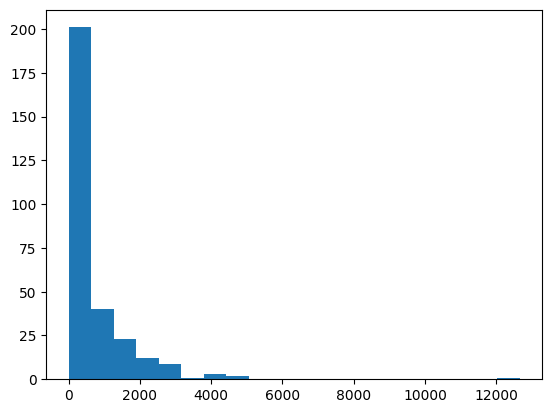

In [6]:
# Plot the distribution of the intervals
plt.hist(interval_and_weather_merged['interval'], bins=20)

interval_and_weather_merged_greater_than_6000 = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5)]
interval_and_weather_merged_greater_than_6000

# remove events with length larger than 5000
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5000)]
interval_and_weather_merged['interval'].max()

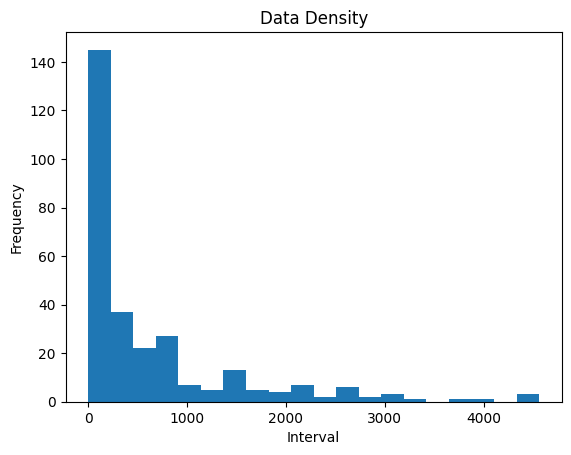

In [7]:
# Data Density Histogram
plt.hist(interval_and_weather_merged['interval'], bins=20)

plt.ylabel("Frequency")
plt.xlabel("Interval")
plt.title("Data Density")

plt.show()

## Initial Cox Regression

In [8]:
interval_and_weather_merged.iloc[0]
# 2 minutes and 13 + 17 seconds = 30
# 150 seconds
# interval_and_weather_merged['interval'] = interval_and_weather_merged['interval'] / 1000000000

interval_and_weather_merged.iloc[0]


Unnamed: 0                                  0
endtime                       0 days 11:41:43
starttime                     0 days 11:44:13
interval                                150.0
departing_insect                      Insecta
arriving_insect                       Insecta
sheet_title             07-28-2022 i10 Zinnia
timestamp_pd              2022-07-28 11:41:43
timestamp_pd_rounded      2022-07-28 12:00:00
same_species                                1
temp                                     23.0
dwpt                                     23.0
rhum                                    100.0
prcp                                      0.0
snow                                      NaN
wdir                                    270.0
wspd                                      7.2
wpgt                                      NaN
pres                                   1014.0
tsun                                      NaN
coco                                      3.0
status                            

In [9]:
# Interval column is in nanoseconds
interval_cut_off = 1*60*1000*1000000
df_less_than_interval = interval_and_weather_merged[(interval_and_weather_merged['interval'] < interval_cut_off) & (interval_and_weather_merged['same_species'] == True)]

df_minus_short_interval_same_insect = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= interval_cut_off) | (interval_and_weather_merged['same_species'] == False)]
# df_minus_short_interval_same_insect

In [10]:
def run_cox_regression_on_all_data(interval_and_weather_merged):
  # JCB: List of ones to represent that all intervals have completed
  status = np.ones(interval_and_weather_merged.shape[0])

  mod = smf.phreg("interval ~ same_species + temp + wspd + dwpt + coco",
                  interval_and_weather_merged, status=status, ties="efron")
  rslt = mod.fit()
  print(rslt.summary())

  return rslt
  
result = run_cox_regression_on_all_data(interval_and_weather_merged)

# status = np.ones(interval_and_weather_merged.shape[0])
# interval_and_weather_merged['status'] = status
# 

                          Results: PHReg
Model:                     PH Reg          Sample size:        291
Dependent variable:        interval        Num. events:        291
Ties:                      Efron                                  
------------------------------------------------------------------
              log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------
same_species  0.3785    0.1323 1.4600  2.8608 0.0042 1.1266 1.8922
temp          0.0523    0.0260 1.0537  2.0084 0.0446 1.0013 1.1088
wspd          0.0129    0.0145 1.0130  0.8890 0.3740 0.9846 1.0422
dwpt         -0.0922    0.0196 0.9119 -4.6961 0.0000 0.8774 0.9477
coco          0.3109    0.0582 1.3647  5.3393 0.0000 1.2175 1.5296
Confidence intervals are for the hazard ratios


In [11]:
# baseline_hazard = result.baseline_hazard[0] # baseline hazard at time 0
# sf = result.survival_function(data, times=[1000]) # survival function at time t=1000
# s_prob = sf[0][0]

print(result.__dir__())
print(result.params)
print(result.model)

['covariance_type', 'df_resid', 'df_model', 'params', 'model', 'k_constant', '_data_attr', '_data_in_cache', 'normalized_cov_params', 'scale', '_use_t', '_cache', '__module__', '__doc__', '__init__', 'standard_errors', 'bse', 'get_distribution', 'predict', '_group_stats', 'weighted_covariate_averages', 'score_residuals', 'baseline_cumulative_hazard', 'baseline_cumulative_hazard_function', 'schoenfeld_residuals', 'martingale_residuals', 'summary', '_get_robustcov_results', 'use_t', 'llf', 'tvalues', 'pvalues', 'cov_params', 't_test', 'f_test', 'wald_test', 'wald_test_terms', 't_test_pairwise', 'conf_int', 'save', 'load', 'remove_data', 'initialize', '__dict__', '__weakref__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
[ 0.37845869  0.05227543  0.01290065

### Checking proportional hazards assumption

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 291 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
coco         km              4.32 0.04      4.73
             rank            4.32 0.04      4.73
dwpt         km              0.50 0.48      1.06
             rank            0.51 0.48      1.07
same_species km              1.69 0.19      2.37
             rank            1.65 0.20      2.33
temp         km              4.90 0.03      5.22
             rank            4.78 0.03      5.12
wspd         km              1.58 0.21      2.26
             rank            1.55 0.21      2.23



1. Variable 'temp' failed the non-proportional test: p-value is 0.0268.

   Advice 1: the functional form of the variable 'temp' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'temp' using pd.cut, and then specify it in `strata=['temp',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'coco' failed the non-proportional test: p-value is 0.0376.

   Advice 1: the functional form of the variable 'coco' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below 

[[<Axes: xlabel='rank-transformed time\n(p=0.0288)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0268)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0377)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0376)'>]]

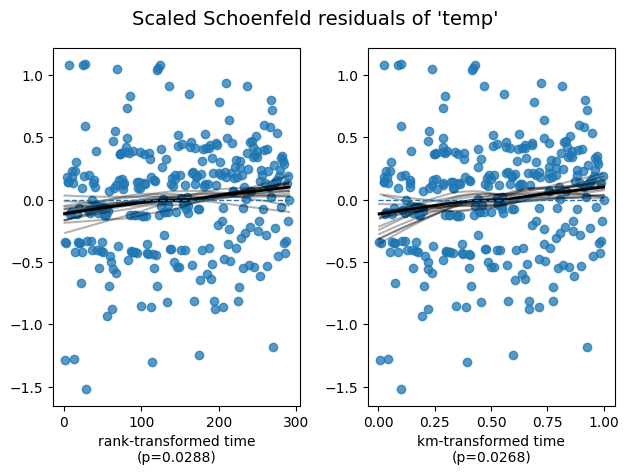

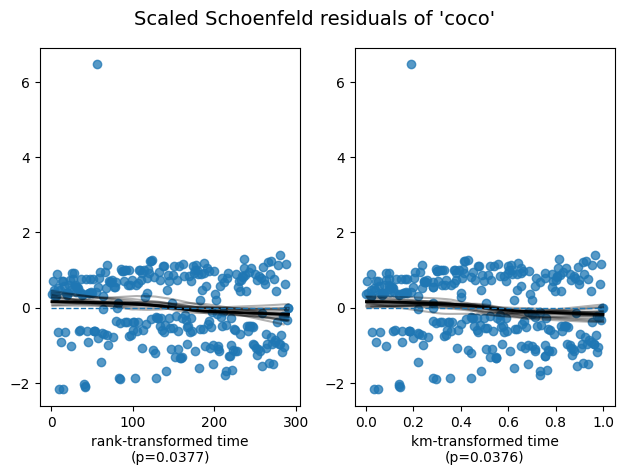

In [12]:
rossi = load_rossi()

# same_species + temp + wspd + dwpt + coco
cph = CoxPHFitter()

trimmed_df = interval_and_weather_merged[['interval','status', 'same_species' , 'temp' , 'wspd' , 'dwpt' , 'coco']].copy()
trimmed_df = trimmed_df.reset_index(drop=True)
cph.fit(trimmed_df, 'interval', 'status')
# cph.print_summary(model="untransformed variables", decimals=3)
cph.check_assumptions(trimmed_df, p_value_threshold=0.05, show_plots=True)
# trimmed_df


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.0007)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0009)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0068)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0063)'>]]

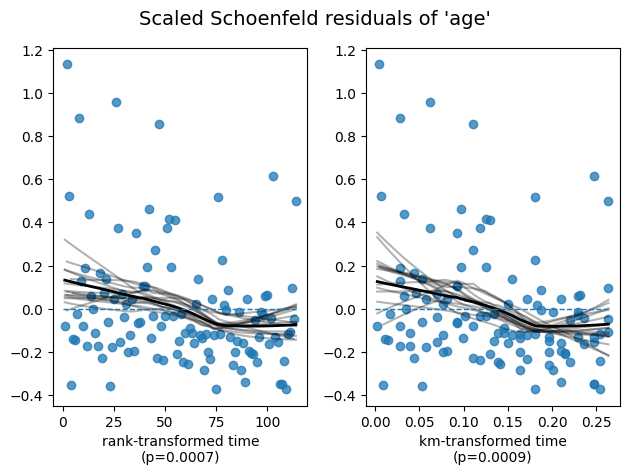

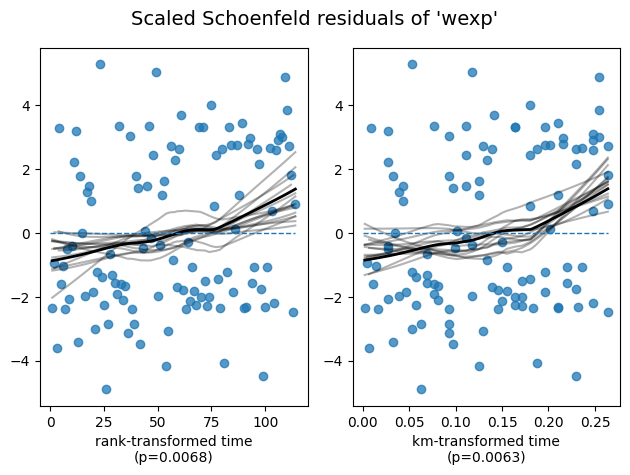

In [13]:
cph.fit(rossi, 'week', 'arrest')
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)
# rossi

### Running classic cox regression with Lifelines on photo data
 

In [20]:
cph = CoxPHFitter()
cph.fit(interval_and_weather_merged, duration_col='interval', event_col='status', formula="same_species + temp + wspd + dwpt + coco")

# cph.print_summary()

cph.confidence_interval_



AttributeError: CoxPHFitter has no attribute 'confidence_interval_'

In [15]:
cph.concordance_index_
# cph.hazard_ratios_
-cph.predict_partial_hazard(interval_and_weather_merged)

0     -0.747965
1     -0.512296
2     -0.591253
3     -0.432622
4     -0.432622
         ...   
287   -0.318643
288   -0.271559
289   -0.271559
290   -0.396483
291   -0.271559
Length: 291, dtype: float64

### Notes from Tom
- For Stacking concordance score. For each event in the test set, get the indivual median survival time, and pass that along with `interval` 
- The ambiguity is what is the meaning of concordance. It is a measure across the set. 

In [16]:
# from lifelines.utils import concordance_index
# import numpy as np
# cph = CoxPHFitter().fit(interval_and_weather_merged, 'interval', 'status')
# concordance_index(interval_and_weather_merged['interval'], -cph.predict_partial_hazard(interval_and_weather_merged), df['status'])

# TODO: Calculate the median survival time for the data

# median_surv_time = 67915000
# # Predicted survival times
# predicted_times = np.full(interval_and_weather_merged.shape[0], median_surv_time) 
# print(predicted_times)
# actual_times = np.array([95, 214, 121, 210, 116, 124])  # Actual survival times
# event_indicator = np.array([1, 1, 1, 1, 1, 1])  # Event indicator (1 if event occurred, 0 otherwise)

#TODO:  Get median value of predicted survival time?

# Calculate the concordance index
c_index = concordance_index(interval_and_weather_merged['interval'], -cph.predict_partial_hazard(interval_and_weather_merged), interval_and_weather_merged['status'])
print("Concordance Index:", c_index)

Concordance Index: 0.6388459618173605


### Notes from Tom
Qualitative 

In [17]:
def run_bin_temp_analysis(df, binned_column, number_of_bins):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])

    group_object = {}
    # Print out the DataFrame grouped by temperature group
    for name, group in interval_and_weather_merged.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_object.update({name: group})
        group_temp_range = f"{name}: {group['temp'].min()} - {group['temp'].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        cph = CoxPHFitter()
        cph.fit(group, duration_col='interval', event_col='status', formula="same_species + temp + wspd + dwpt + coco")

        cph.print_summary()

        # mod = smf.phreg("interval ~ same_species + temp + wspd + dwpt + coco",
        #                 group, status=status, ties="efron")
        # rslt = mod.fit()
        # print(rslt.summary())
    return group_object
    
# df_minus_short_interval_same_species

temp_groups = run_bin_temp_analysis(interval_and_weather_merged, 'temp', 3)

temp_groups

Photo data temp range
12.0
31.0
6.333333333333333
Group: Low

Number of rows in group: 80

group_temp_range Low: 14.0 - 18.0


<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 80
   partial log-likelihood = -260.26
         time fit was run = 2023-08-10 02:46:33 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
coco           0.46       1.58       0.13             0.21             0.71                 1.24                 2.03
dwpt          -0.19       0.83       0.05            -0.30            -0.08                 0.74                 0.92
same_species  -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.89
temp          -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
wspd           0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06

               cmp to     z      p   -log2(p)
covariate                                    
coco             0.00  3.65 <0.005      11.89
dwpt             0.00 -3.48 <0.005      10.95
same_species     0.00 -0.22   0.83       0.27
temp             0.00 -0.46   0.65       0.63
wspd             0.00  0.65   0.51       0.96
---
Concordance = 0.69
Partial AIC = 530.52
log-likelihood ratio test = 26.83 on 5 df
-log2(p) of ll-ratio test = 13.99

Group: Medium

Number of rows in group: 156

group_temp_range Medium: 20.0 - 24.0


<lifelines.CoxPHFitter: fitted with 156 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 156
number of events observed = 156
   partial log-likelihood = -618.74
         time fit was run = 2023-08-10 02:46:33 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
coco           0.31       1.37       0.09             0.14             0.49                 1.15                 1.63
dwpt          -0.10       0.91       0.03            -0.15            -0.05                 0.86                 0.95
same_species   0.40       1.49       0.17             0.06             0.74                 1.06                 2.09
temp           0.04       1.04       0.08            -0.11             0.20                 0.90                 1.22
wspd           0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06

               cmp to     z      p   -log2(p)
covariate                                    
coco             0.00  3.46 <0.005      10.88
dwpt             0.00 -3.88 <0.005      13.22
same_species     0.00  2.31   0.02       5.57
temp             0.00  0.55   0.58       0.78
wspd             0.00  0.49   0.62       0.69
---
Concordance = 0.65
Partial AIC = 1247.48
log-likelihood ratio test = 32.97 on 5 df
-log2(p) of ll-ratio test = 18.00

Group: High

Number of rows in group: 49

group_temp_range High: 25.0 - 31.0


<lifelines.CoxPHFitter: fitted with 49 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 49
number of events observed = 49
   partial log-likelihood = -140.73
         time fit was run = 2023-08-10 02:46:34 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
coco          -0.12       0.89       0.25            -0.62             0.38                 0.54                 1.46
dwpt          -0.26       0.77       0.14            -0.53             0.01                 0.59                 1.01
same_species   0.39       1.48       0.31            -0.21             0.99                 0.81                 2.70
temp           0.39       1.47       0.21            -0.02             0.79                 0.98                 2.21
wspd           0.02       1.02       0.05            -0.08             0.12                 0.92                 1.13

               cmp to     z    p   -log2(p)
covariate                                  
coco             0.00 -0.48 0.63       0.66
dwpt             0.00 -1.90 0.06       4.12
same_species     0.00  1.28 0.20       2.31
temp             0.00  1.87 0.06       4.03
wspd             0.00  0.44 0.66       0.60
---
Concordance = 0.52
Partial AIC = 291.45
log-likelihood ratio test = 7.68 on 5 df
-log2(p) of ll-ratio test = 2.52

{'Low':      Unnamed: 0          endtime        starttime  interval  \
 14           14  0 days 12:02:30  0 days 12:17:00     870.0   
 15           15  0 days 12:17:30  0 days 12:29:00     690.0   
 16           16  0 days 12:29:30  0 days 12:39:00     570.0   
 87          262  0 days 00:09:54  0 days 00:10:26      32.0   
 88          263  0 days 00:12:39  0 days 00:13:18      39.0   
 ..          ...              ...              ...       ...   
 237         259  0 days 00:26:00  0 days 00:48:45    1365.0   
 238         260  0 days 00:48:56  0 days 01:09:20    1224.0   
 239         261  0 days 00:36:55  0 days 00:37:46      51.0   
 286          40  0 days 12:12:26  0 days 12:37:56    1530.0   
 287          43  0 days 12:17:54  0 days 13:09:55    3121.0   
 
             departing_insect          arriving_insect  \
 14   Melissodes denticulatus  Melissodes denticulatus   
 15   Melissodes denticulatus  Melissodes denticulatus   
 16   Melissodes denticulatus  Melissodes denticu

In [18]:
# Summary Stats about Reyna's Data
print(interval_and_weather_merged_reyna.temp.quantile([0.25,0.5,0.75]))

print(interval_and_weather_merged.temp.quantile([0.25,0.5,0.75]))

NameError: name 'interval_and_weather_merged_reyna' is not defined

### New binning analysis function but for time

In [ ]:
def run_bin_time_analysis(interval_and_weather_merged, binned_column, number_of_bins):
    # Convert the 'Timestamp' column to datetime format
    interval_and_weather_merged[binned_column] = pd.to_datetime(interval_and_weather_merged[binned_column])

    # Extract the hour component from each timestamp
    interval_and_weather_merged['hour_of_day'] = interval_and_weather_merged[binned_column].dt.hour

    # Calculate the range of the hour_of_day values
    time_min = interval_and_weather_merged['hour_of_day'].min()
    time_max = interval_and_weather_merged['hour_of_day'].max()

    print(f"Photo data {binned_column} range")
    print(time_min)
    print(type(time_min))
    print(time_max)

    # Calculate the range of each group based on the total range of hour_of_day
    group_range = (time_max - time_min) / number_of_bins
    print(group_range)

    # Create the bins for the pd.cut function
    bins = [time_min + i * group_range for i in range(number_of_bins + 1)]

    print('bins', bins)
    # Create a new column in the DataFrame to hold the time group for each row
    interval_and_weather_merged['time_group'] = pd.cut(
        interval_and_weather_merged['hour_of_day'],
        bins=bins,
        labels=[f'Group {i+1}' for i in range(number_of_bins)]
    )

    # Drop the intermediate hour_of_day column if needed
    # interval_and_weather_merged.drop('hour_of_day', axis=1, inplace=True)



    # Print out the DataFrame grouped by time group
    for name, group in interval_and_weather_merged.groupby('time_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        # print(group.head())
        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_species + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_species

run_bin_time_analysis(interval_and_weather_merged, 'timestamp_pd_rounded', 3)

Photo data timestamp_pd_rounded range
12
<class 'numpy.int64'>
17
1.6666666666666667
bins [12.0, 13.666666666666666, 15.333333333333334, 17.0]
Group: Group 1

Number of rows in group: 38



                         Results: PHReg
Model:                     PH Reg          Sample size:        38
Dependent variable:        interval        Num. events:        38
Ties:                      Efron                                 
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect  0.7276    0.4988 2.0700  1.4585 0.1447 0.7787 5.5029
temp        -0.0486    0.1315 0.9526 -0.3692 0.7120 0.7361 1.2327
wspd         0.0535    0.0511 1.0550  1.0468 0.2952 0.9544 1.1661
dwpt         0.0508    0.1228 1.0521  0.4135 0.6792 0.8270 1.3384
coco         0.1464    0.2185 1.1576  0.6699 0.5029 0.7544 1.7764
Confidence intervals are for the hazard ratios
Group: Group 2

Number of rows in group: 164

                         Results: PHReg
Model:                      PH Reg         Sample size:       164
Dependent variable:         interva

In [ ]:
interval_and_weather_merged

# Convert the 'Timestamp' column to datetime format
interval_and_weather_merged['timestamp_pd_rounded'] = pd.to_datetime(interval_and_weather_merged['timestamp_pd_rounded'])

# Find the earliest hour value
earliest_hour = interval_and_weather_merged['timestamp_pd_rounded'].dt.hour.max()

type(earliest_hour)
# pd.to_datetime(earliest_hour.astype(str)).values

# datetime_time_min = np.datetime64(earliest_hour, 'h')
interval_and_weather_merged['timestamp_pd_rounded']

0    2022-07-28 12:00:00
1    2022-07-28 12:00:00
2    2022-07-28 14:00:00
3    2022-08-04 13:00:00
4    2022-08-04 13:00:00
             ...        
41   2022-08-25 12:00:00
42   2022-08-25 13:00:00
43   2022-08-25 13:00:00
44   2022-08-25 13:00:00
45   2022-08-25 13:00:00
Name: timestamp_pd_rounded, Length: 291, dtype: datetime64[ns]

## Pycox Expirementation


### Initial Walkthrough of Pycox

In [ ]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
df_train = interval_and_weather_merged[cols_input]

# print(df_train['interval'].max())

# Step 2: Split data into training, validation, and test sets
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,interval,status,temp,dwpt,wspd,coco,same_insect
0,150.0,1,23.0,23.0,7.2,3.0,1
1,1170.0,1,23.0,23.0,7.2,3.0,0
3,124.0,1,28.0,25.0,7.0,1.0,1
4,31.0,1,28.0,25.0,7.0,1.0,1
5,93.0,1,28.0,25.0,7.0,1.0,1


In [ ]:
cols_standardize = []
cols_leave = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_val

array([[1.500e+03, 1.000e+00, 2.400e+01, 2.210e+01, 1.300e+01, 3.000e+00,
        1.000e+00],
       [6.600e+02, 1.000e+00, 2.900e+01, 2.500e+01, 8.300e+00, 3.000e+00,
        0.000e+00],
       [1.380e+02, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        1.000e+00],
       [1.090e+02, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [5.000e+00, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [6.700e+01, 1.000e+00, 2.200e+01, 8.100e+00, 7.000e+00, 3.000e+00,
        1.000e+00],
       [6.700e+01, 1.000e+00, 1.600e+01, 9.000e+00, 1.480e+01, 1.000e+00,
        1.000e+00],
       [6.900e+01, 1.000e+00, 2.300e+01, 1.610e+01, 1.120e+01, 3.000e+00,
        1.000e+00],
       [1.108e+03, 1.000e+00, 2.200e+01, 8.100e+00, 7.000e+00, 3.000e+00,
        0.000e+00],
       [9.000e+01, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [1.180e+02, 1.000e+00, 1.500e+01, 4.100e+00, 1.300e+0

In [ ]:
num_durations = 100

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['interval'].values, df['status'].values)

# I do not understand the output of the labtrans.fit_transform() function
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
print(y_train)

(array([ 4, 26,  3,  1,  3, 47, 20, 60, 46,  1,  1, 10,  3,  5,  6,  1,  2,
        1,  1,  2,  4,  1,  2,  1,  4, 18,  8, 11,  8,  1,  2, 10,  3,  2,
        2, 15,  1,  1,  1,  3,  1,  4,  2,  3,  4,  4,  3,  1,  7,  5,  6,
        5,  3,  2,  3,  9,  1, 60,  7, 18, 18, 42, 20, 35,  6, 56,  8,  2,
        8,  4, 16,  6, 14, 38, 18,  2, 43, 18, 47, 12, 16,  7, 99, 14,  7,
        1,  1,  3,  5,  2,  6,  2,  3,  5,  2,  4,  4,  1, 14,  3,  7,  2,
        8, 11, 21, 75, 32, 28,  2, 20, 57,  3, 13,  2,  4,  5,  8,  8,  6,
       17, 12,  1, 46,  4,  1,  1,  4,  7,  4,  1,  1, 10,  5,  4,  7,  8,
       42, 17,  5, 33, 31, 28,  2,  1,  4,  1,  1, 34, 33,  1,  5, 10,  1,
        2, 17, 40, 22, 29, 33,  4, 14, 19]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
bad_param = 'test'
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)



INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah


0:	[0s / 0s],		train_loss: 10.5926,	val_loss: 12.2561
1:	[0s / 0s],		train_loss: 8.6730,	val_loss: 7.7127
2:	[0s / 0s],		train_loss: 7.3488,	val_loss: 6.0159
3:	[0s / 0s],		train_loss: 6.4143,	val_loss: 5.1427
4:	[0s / 0s],		train_loss: 5.6587,	val_loss: 4.6233
5:	[0s / 0s],		train_loss: 4.9796,	val_loss: 4.3016
6:	[0s / 0s],		train_loss: 4.5022,	val_loss: 4.0988
7:	[0s / 0s],		train_loss: 4.1005,	val_loss: 3.9936
8:	[0s / 0s],		train_loss: 3.7801,	val_loss: 3.9419
9:	[0s / 0s],		train_loss: 3.4942,	val_loss: 3.9060
10:	[0s / 0s],		train_loss: 3.2773,	val_loss: 3.8627
11:	[0s / 0s],		train_loss: 3.1645,	val_loss: 3.8131
12:	[0s / 0s],		train_loss: 3.0462,	val_loss: 3.7311
13:	[0s / 0s],		train_loss: 2.9519,	val_loss: 3.6244
14:	[0s / 0s],		train_loss: 2.7656,	val_loss: 3.5097
15:	[0s / 0s],		train_loss: 2.7018,	val_loss: 3.3913
16:	[0s / 0s],		train_loss: 2.6250,	val_loss: 3.2806
17:	[0s / 0s],		train_loss: 2.5492,	val_loss: 3.2005
18:	[0s / 0s],		train_loss: 2.4757,	val_loss: 3.1388
1

### run_pycox_on_group and evaluationg functions

INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah


NameError: name 'val' is not defined

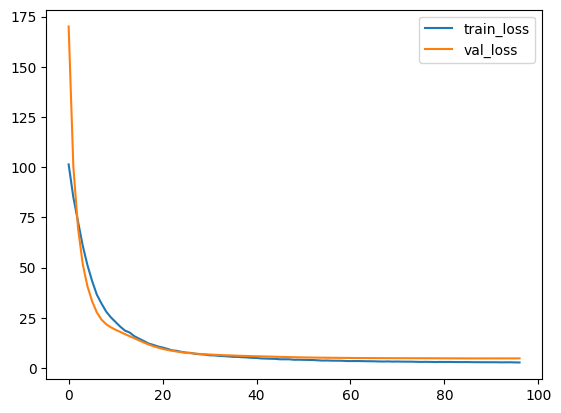

In [ ]:
# Creating Pycox Function
# def run_pycox_on_group(df):
#   # Step 2: Split data into training, validation, and test sets
#   df_test = df.sample(frac=0.2)
#   df_train = df.drop(df_test.index)
#   df_val = df.sample(frac=0.2)
#   df_train = df.drop(df_val.index)

#   cols_standardize = []
#   cols_leave = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']

#   standardize = [([col], StandardScaler()) for col in cols_standardize]
#   leave = [(col, None) for col in cols_leave]

#   x_mapper = DataFrameMapper(standardize + leave)
#   x_train = x_mapper.fit_transform(df_train).astype('float32')
#   x_val = x_mapper.transform(df_val).astype('float32')
#   x_test = x_mapper.transform(df_test).astype('float32')

#   num_durations = 100
#   labtrans = LogisticHazard.label_transform(num_durations)
#   get_target = lambda df: (df['interval'].values, df['status'].values)
#   y_train = labtrans.fit_transform(*get_target(df_train))
#   y_val = labtrans.transform(*get_target(df_val))
#   train = (x_train, y_train)
#   val = (x_val, y_val)

#   # We don't need to transform the test labels
#   durations_test, events_test = get_target(df_test)

#   in_features = x_train.shape[1]
#   num_nodes = [32, 32]
#   out_features = labtrans.out_features
#   batch_norm = True
#   dropout = 0.1

#   net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

#   model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
#   batch_size = 256
#   epochs = 100
#   bad_param = 'test'
#   callbacks = [tt.cb.EarlyStopping()]
#   log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose=0)

#   return log, model, x_test, df_test, x_mapper

def plot_training_val_loss(fit_model, base_model, x_test):
  _ = fit_model.plot()
  fit_model.to_pandas().val_loss.min()
  base_model.score_in_batches(val)
  surv = base_model.predict_surv_df(x_test)
  plt.ylabel('S(t | x)')
  _ = plt.xlabel('Time')
  surv.iloc[:, :1]

# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
df_intervals = interval_and_weather_merged[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_intervals, 1000)


plot_training_val_loss(fit_model, base_model, x_test)

In [ ]:
def graph_mean_and_sem(surv, group_name):
  surv['mean'] = surv.mean(axis=1)
  surv['sem'] = surv.sem(axis='columns')
  
  # Calculate the upper and lower error bounds
  surv['upper_bound'] = surv['mean'] + surv['sem']
  surv['lower_bound'] = surv['mean'] - surv['sem']

  # Create the figure and axis objects
  fig, ax = plt.subplots()

  # Plot the mean line
  ax.plot(surv.index, surv['mean'], color='blue', label='Mean')

  # Plot the error bars
  ax.errorbar(surv.index, surv['mean'], yerr=surv['sem'], color='red', label='Error Bars')

  # Fill between the upper and lower error bounds
  ax.fill_between(surv.index, surv['lower_bound'], surv['upper_bound'], color='red', alpha=0.3)

  # Set the axis labels and title
  ax.set_xlabel('Time (In Seconds)')
  ax.set_ylabel('S(t | x)')
  ax.set_title(f'{group_name} Group Estimated Population with Error Bars')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.show()

# graph_mean_and_sem(surv, 'x_test')

In [ ]:
for group in temp_groups:
  print(group)
  df = temp_groups[group]
  cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
  df_train = df[cols_input]
  fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_train, 1000)
  surv = base_model.predict_surv_df(x_test)
  graph_mean_and_sem(surv, f'{group} Temperature')
  # plot_training_val_loss(fit_model, base_model, x_test)
  
  

NameError: name 'temp_groups' is not defined

### Evaluation of trained model

Notes:
- From our graphed 5 rows from the `x_train` dataset we can see that the survival curves all have a sharp decrease after the first few seconds. 

TODO:
- Need to figure out why the discretization grid values are so strange
- 
~~- See if you can run the EvalSurv functions in google colab on the bee data~~

<Axes: >

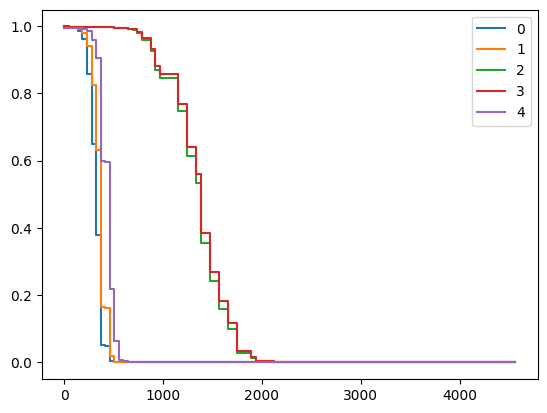

In [ ]:
surv = model.predict_surv_df(x_test)

surv.iloc[:, :5].plot(drawstyle='steps-post')

0.000000       2.275091e-04
46.070707      5.628167e-02
92.141414      5.988117e-02
138.212121     6.003413e-02
184.282828     6.064958e-02
                   ...     
4376.717172    5.989969e-04
4422.787879    5.988123e-04
4468.858586    5.975952e-04
4514.929293    5.973267e-04
4561.000000    1.810738e-07
Name: sem, Length: 100, dtype: float32

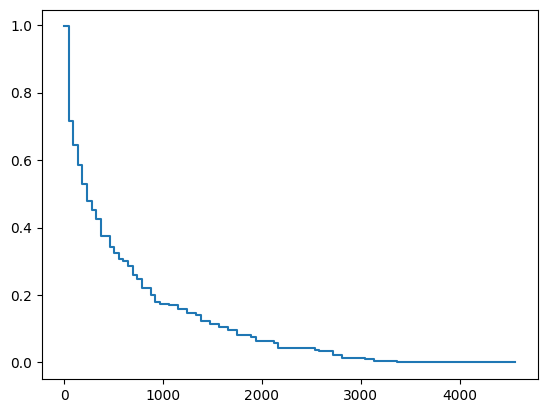

In [ ]:
# calculate the mean and standard error mean
surv['mean'] = surv.mean(axis=1)
surv['sem'] = surv.sem(axis='columns')

surv['mean'].plot(drawstyle='steps-post')

surv['sem']

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,mean,sem
0.0,0.994813,0.99488,0.998174,0.998235,0.994948,0.993903,0.99026,0.994804,0.999063,0.996478,...,0.996912,0.998559,0.9946,0.998508,0.995106,0.993404,0.996413,0.994667,0.996034,0.000228


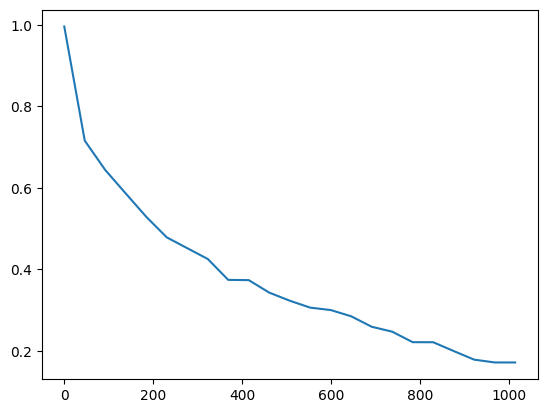

In [ ]:
# Plotting the population survival curve for the time slice 0-1000 
surv['mean'].iloc[:23].plot()



# print(surv.iloc[:1].sem(axis='columns'))
surv.iloc[:1]

### Linear Regression on the time segment

TODO:
- I think actually, I should just be running the cox regression hazards method on this time segment. How do I feed it data on the covariates that are static across the entire survival curve? ASK THIS TO TOM?


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
slope b1 is -0.0007580595874057576
intercept b0 is 0.6313749170471117


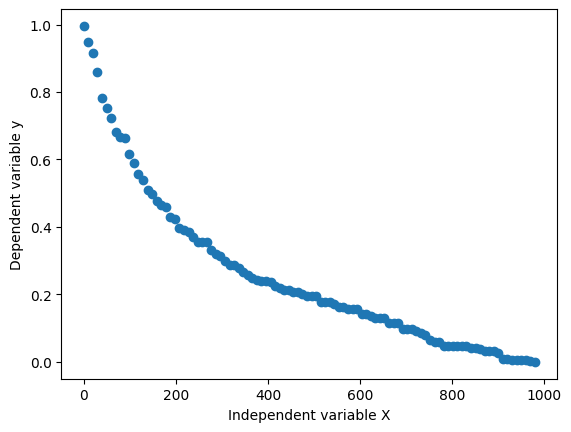

In [ ]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
interval_and_weather_merged_under_1000 = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 1000)]
df_interval_and_weather_merged_under_1000 = interval_and_weather_merged_under_1000[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_interval_and_weather_merged_under_1000)
surv = base_model.predict_surv_df(x_test)

# Predict the slope and coefficients for time segment
# TODO: decide if these items should become a function 
surv['mean'] = surv.mean(axis=1)
surv['sem'] = surv.sem(axis='columns')

def run_linear_regression(surv):
  x = surv.index.values
  y = surv['mean'].values
  n = np.size(x)

  x_mean = np.mean(x)
  y_mean = np.mean(y)
  x_mean,y_mean

  Sxy = np.sum(x*y)- n*x_mean*y_mean
  Sxx = np.sum(x*x)-n*x_mean*x_mean

  b1 = Sxy/Sxx
  b0 = y_mean-b1*x_mean
  print('slope b1 is', b1)
  print('intercept b0 is', b0)

  plt.scatter(x,y)
  plt.xlabel('Independent variable X')
  plt.ylabel('Dependent variable y')

run_linear_regression(surv)

In [ ]:
# TODO make the lt(.5) a data point
def format_survival_data(surv, less_than_value):


    # Find index values where each column is less than 0.5
    less_than_half = surv.lt(less_than_value)

    # Get the first index where the condition is true for each column
    first_less_than_half = less_than_half.idxmax()

    # Print the index values
    # for column in first_less_than_half.index:
    #     print(f"Column {column}:")
    #     print(first_less_than_half[column])
    #     print()


    return np.array(first_less_than_half)

# surv.drop(['sem', 'mean'], inplace=True, axis=1)
# first_less_than_half_array = format_survival_data(surv, .5)


In [ ]:
# Multiple Regression
def run_multiple_regression(df_test, surv):
  first_less_than_half_array = format_survival_data(surv, .1)
  x = df_test.drop(['status', 'interval'], axis=1)

  # Create the dependent variable
  y = first_less_than_half_array

  # Create the regression model
  model = LinearRegression()

  # Fit the model to the data
  model.fit(x, y)

  # Get the coefficients
  coefficients = pd.DataFrame(zip(x.columns, model.coef_))

  # Get the intercept
  intercept = model.intercept_

  # Print the results
  print('Coefficients:', coefficients)
  print('Intercept:', intercept)

# Run the regression with statsmodels
# model2 = ols(formula='interval ~ same_insect + temp + wspd + dwpt + coco', data=data)
# results = model2.fit()

# # Print the results from statsmodels
# print(results.summary())

# run_multiple_regression(df_test, first_less_than_half_array)

In [ ]:
# Moving the cut-off of first 1000 seconds to after training pycox model
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
interval_and_weather_merged = interval_and_weather_merged[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(interval_and_weather_merged)

df_test_under_1000 = df_test[(df_test['interval'] <= 1000)]
x_test_under_1000 = x_mapper.transform(df_test_under_1000).astype('float32')
surv = base_model.predict_surv_df(x_test_under_1000)

run_multiple_regression(df_test_under_1000, surv)


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Coefficients:              0          1
0         temp  -5.242918
1         dwpt  27.589583
2         wspd -11.052137
3         coco -67.581464
4  same_insect -43.866444
Intercept: 297.5685731534929


In [ ]:
# Base case first 100 seconds
interval_and_weather_merged
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(interval_and_weather_merged)
surv = base_model.predict_surv_df(x_test_under_1000)

# Manually calculate the slope of the population survival curve for the time-segment

# run a regression with the data and from the test and the slope

In [ ]:
# First 100 seconds regression
df_test_under_100 = df_test[(df_test['interval'] <= 100)]
x_test_under_100 = x_mapper.transform(df_test_under_100).astype('float32')
surv = base_model.predict_surv_df(x_test_under_100)
surv['mean'] = surv.mean(axis=1)
surv['sem'] = surv.sem(axis='columns')

first_less_than_half_array = format_survival_data(surv)

run_multiple_regression(df_test_under_100, surv)


NameError: name 'df_test' is not defined

In [ ]:
# Double check the matching up of your datasets
### Notes from Tom
# Use data from all events that are still active + all the ones that have changed?
# What is leaving someone in the active queue. 
# If we do the time-interval 75-100 
# From the covariates can we predict the slope of the kaplin-meir population curve during the window 75-100. 
# As we censor from the left we are still tracking the data that hasn't terminated. 
# Moving function of the data 
df_test_under_100

,interval,status,temp,dwpt,wspd,coco,same_insect
140,15.0,1,14.0,10.0,0.7,3.0,0
36,30.0,1,23.0,23.0,0.0,1.0,1
5,93.0,1,28.0,25.0,7.0,1.0,1
46,43.0,1,23.0,16.1,11.2,3.0,0
28,19.0,1,22.0,16.1,13.0,3.0,0
43,25.0,1,23.0,16.1,11.2,3.0,1
63,90.0,1,25.0,17.0,13.0,3.0,1
135,98.0,1,14.0,10.0,0.7,3.0,1
70,5.0,1,25.0,17.0,13.0,3.0,0
50,86.0,1,23.0,16.1,11.2,3.0,1


In [ ]:
surv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0.000000,0.997937,0.996105,0.994307,0.996989,0.996438,0.996863,0.996541,0.996756,9.972495e-01,0.996636,0.997390,0.996707,0.996897,0.997113,0.996641,0.996492,9.965137e-01,0.995231
9.888889,0.973021,0.989979,0.992512,0.992575,0.980653,0.990932,0.993158,0.992089,1.252960e-02,0.993190,0.993659,0.990820,0.993503,0.990797,0.991754,0.991753,4.722922e-03,0.991439
19.777778,0.306301,0.811803,0.990880,0.971424,0.681740,0.928670,0.990438,0.987976,1.320211e-08,0.990042,0.978426,0.937554,0.988352,0.971187,0.940351,0.982150,1.598323e-09,0.934851
29.666667,0.015316,0.396268,0.989279,0.890691,0.122071,0.622021,0.987203,0.982419,1.320214e-15,0.985936,0.923297,0.683506,0.978934,0.906203,0.710476,0.959160,1.598324e-16,0.711185
39.555556,0.000136,0.031958,0.982404,0.564880,0.003257,0.118483,0.979419,0.972149,2.894027e-22,0.975223,0.654997,0.174708,0.946595,0.685894,0.179125,0.880181,1.598324e-23,0.143055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939.444444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
949.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
959.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
969.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000


In [ ]:
# Plot the varouis covariates by the first_less_than_half_array

# plt.scatter(df_test_under_100['temp'],first_less_than_half_array)


for column in df_test_under_100.columns:
    # Create a scatter plot for the current column
    plt.scatter(df_test_under_100[column], first_less_than_half_array)
    
    # Set plot title and labels
    plt.title(f'Scatter plot of {column} vs. predicted survival')
    plt.xlabel(column)
    plt.ylabel('predicted survival < .5')
    
    # Show the plot
    plt.show()

In [ ]:
# Use Scikit to validate the results from manual regression
x = x.reshape(-1,1)
regression_model = LinearRegression()

# Fit the data(train the model)
regression_model.fit(x, y)

# Predict
y_predicted = regression_model.predict(x)

# model evaluation
mse=mean_squared_error(y,y_predicted)

rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('MSE:',mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [-0.00010606]
Intercept: 0.36274479275150323
MSE: 0.011708086199077776
Root mean squared error:  0.10820391027628241
R2 score:  0.6295185444717775


### Older cells for evaluating

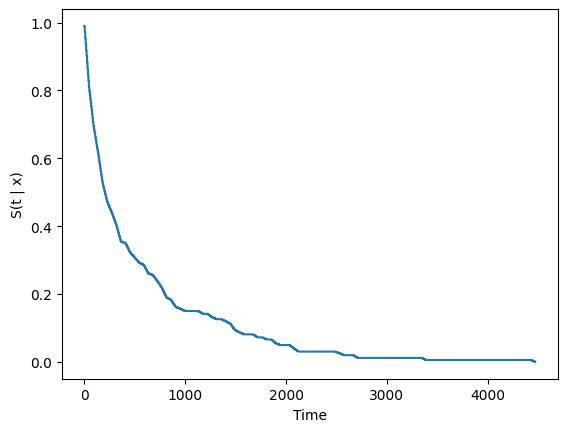

In [ ]:

# start by interpolating
surv = model.interpolate(10).predict_surv_df(x_train)

# calculate the mean
surv['mean'] = surv.mean(axis=1)

surv['mean'].plot(drawstyle='steps-post')

plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

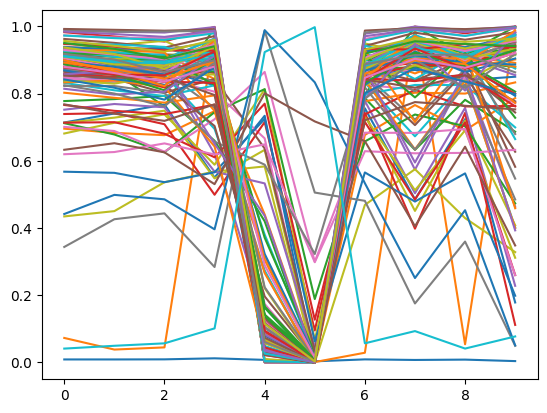

In [ ]:
# _ = log.plot()
# log.to_pandas().val_loss.min()
# model.score_in_batches(val)
surv = model.predict_hazard(x_test)
# surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.plot(surv)
plt.show()
surv

model.save_model_weights('./model_weights.txt')

,0
0.000000,0.990979
45.161616,0.918654
90.323232,0.060566
135.484848,0.001034
180.646465,0.000009
...,...
4290.353535,0.000000
4335.515152,0.000000
4380.676768,0.000000
4425.838384,0.000000


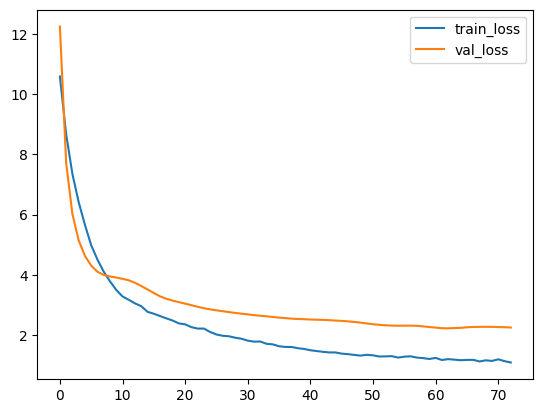

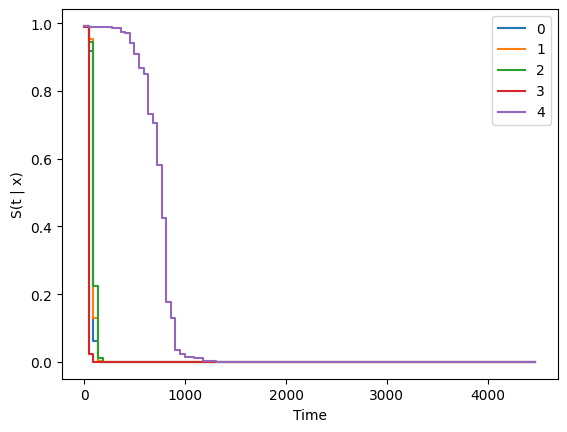

In [ ]:
_ = log.plot()
log.to_pandas().val_loss.min()
model.score_in_batches(val)
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
# S(t | x) is the survival curve
# Assumption is this is the discrete data. The events they are fitting on is coming in discrete windows
# Our photo data has a consistent discretization grid in that we are checking in on the process every 30 seconds
# 
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
surv.iloc[:, :1]

- The plot below is the predicted survaval estimates of the first 5 individuals in the `x_test` dataset

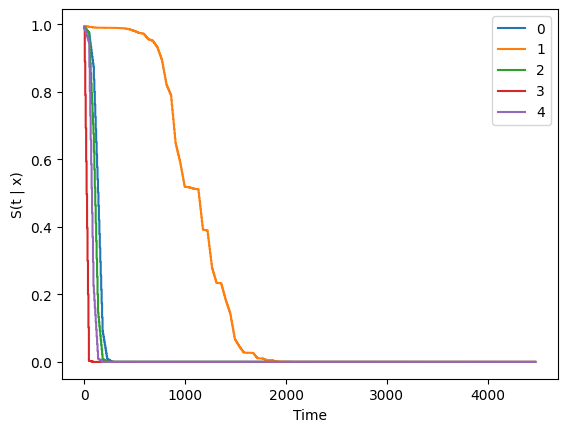

In [ ]:
# TODO: Get some text output from this 
surv = model.interpolate(10).predict_surv_df(x_train)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
# surv_cdi = model.interpolate(100).predict_surv_df(x_test)
# ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
# ev_cdi.concordance_td()

### Old Attempt for training

In [ ]:
# Extract input features and output label
x = interval_and_weather_merged[['temp', 'dwpt', 'wspd', 'coco', 'same_species']]
y = interval_and_weather_merged[['interval', 'status']]

x = x.astype({'same_species': 'float64'})
y = y.astype({'interval': 'float64', 'status': 'float64'})

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(y_train.head())

# TODO: Skipping the step with the DataFrameMapper function



# Transform output label
get_target = lambda df: (df['interval'].values, df['status'].values)
labtrans = LogisticHazard.label_transform(cuts=100)
y_train_trans = labtrans.fit_transform(*get_target(y_train))

y_train_trans = (np.array(y_train_trans[0], dtype='float64'), np.array(y_train_trans[1], dtype='float64'))



# labtrans.cuts
print(type(labtrans.transform(*get_target(y_val))))
print(y_train_trans[1].dtype)
# print(x_train.values.dtype)

     interval  status
262    2062.0     1.0
271     314.0     1.0
268      67.0     1.0
73       76.0     1.0
25       14.0     1.0
<class 'tuple'>
float64


In [ ]:

# Define model architecture
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Transform output label to `float64` for validation set
y_val_trans = labtrans.transform(*get_target(y_val))
y_val_trans = tuple(np.array(x, dtype='float64') for x in y_val_trans)
print(y_val_trans[0].dtype)
print(y_val_trans[1].dtype)
print(y_train_trans[0].dtype)
print(y_train_trans[1].dtype)
print(x_train.values.dtype)
print(x_val.values.dtype)
print(x_train.isna().sum())
print(y_train_trans.isna().sum())


# Train model
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
# Checking types 
log = model.fit(x_train.values, y_train_trans, batch_size, epochs, callbacks, val_data=(x_val.values, y_val_trans))


float64
float64
float64
float64
float64
float64
temp           0
dwpt           0
wspd           0
coco           0
same_insect    0
dtype: int64


AttributeError: 'tuple' object has no attribute 'isna'

In [ ]:
print("x_train shape:", x_train.values.shape)
print("y_train_trans[0] shape:", y_train_trans[0].shape)
print("y_train_trans[1] shape:", y_train_trans[1].shape)
print("x_val shape:", x_val.values.shape)
print("y_val_trans[0] shape:", y_val_trans[0].shape)
print("y_val_trans[1] shape:", y_val_trans[1].shape)

x_train shape: (233, 5)
y_train_trans[0] shape: (233,)
y_train_trans[1] shape: (233,)
x_val shape: (59, 5)
y_val_trans[0] shape: (59,)
y_val_trans[1] shape: (59,)


,0
0.000000,9.969695e-01
46.070707,9.942567e-01
92.141414,9.938170e-01
138.212121,9.938079e-01
184.282828,9.937838e-01
...,...
4376.717172,1.216293e-06
4422.787879,1.212397e-06
4468.858586,1.201899e-06
4514.929293,1.198898e-06


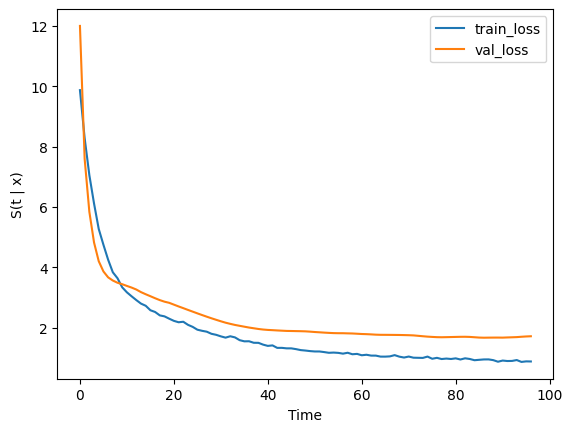

## Stacking Implimentation 
Pseudo Code
Create the predictor matrix and binary response vector for one observation/row
Okay so from the example in the Tibshirani paper what we will do for a given row of our data frame is take the `interval` value and check to see all of the other rows which interval values >= that ‘interval length
Then, we will make  a risk set with the index of our given row and all the rows that met the criteria above. 

Then, we will make our predictor matrix X(R(i)) with the covariants (temp, wspd, etc) for each row that met that hasn’t terminated yet as a row in the predictor matrix
 We then create a binary response vector \hat{y}(R(i)) 
Stack the binary response vectors
Stack the predictor matrix and add i columns for each observation in the risk set. And these column become indicator variables (1 or 0) for weather the observation corresponds to that ith member of the risk set. 
We know apply a binary classifier in order to predict the binary response vector using the predictor matrix. 
This is modeling the conditional proba of having an event at each failure time, having survived the past and previous failure times. 
TODO: Find a binary classification function and feed in our stacked predictor matrix and binary response vector. 
Statsmodels will have one. 


In [ ]:
def stack_dataframe(df):
  predictor_matrix_dfs = []
  binary_response_vector_df = []

  # iterate through each row in the dataframe
  for i, row in df.iterrows():
    # extract the 'interval' value of the current row
    current_interval = row['interval']
    print('current_interval', current_interval)
    print('index', i)
    # use boolean indexing to filter the rows where 'interval' value is greater than the current interval
    risk_set_df = df[df['interval'] >= current_interval]
    print('risk_set_df\n', risk_set_df)
    column_name = f"risk set {i}"  # set the column name variable
    predictor_df = risk_set_df.assign(**{column_name: 1}) 
    
    print('predictor_df\n', predictor_df.iloc[:,-1:])

    # add the risk_set_df dataframe to the list
    predictor_matrix_dfs.append(predictor_df)

    # create binary response vector

    # TODO: This part is not working. We are not placing the 1s in the right place. And we are also not getting the right index when we 
    # calculate the `current_row_predictor_matrix_index` it seems like we are getting more than one value from the get_loc
    current_row_predictor_matrix_index = predictor_df.index.get_loc(i)
    print('current_row_predictor_matrix_index', current_row_predictor_matrix_index)
    indicator_series = pd.Series([0] * len(risk_set_df))

    indicator_series[current_row_predictor_matrix_index] = 1

    print('indicator_series\n', indicator_series)
    # print('current_row', predictor_df.iloc[i])

    # add the binary response vector to the vector list 
    binary_response_vector_df.append(indicator_series)
    
    if i==3:
      break
  
  print(predictor_matrix_dfs)
  # combine predictor matrix dataframes horizontally
  # TODO: This is not working correctly. Instead, this should smash them horizontall. We should end up with many more than 45 rows
  stacked_predictor_df = pd.concat(predictor_matrix_dfs, axis=0)

  # combine binary response vector dataframes horizontally
  stacked_binary_response_df = pd.concat(binary_response_vector_df, axis=0)

  return stacked_predictor_df, stacked_binary_response_df
    

cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
df_input = interval_and_weather_merged[cols_input]

stacked_predictor_df, stacked_binary_response_df = stack_dataframe(df_input)
stacked_predictor_df

# Replace NaN values with zeros for indicator columns `risk set 1`
# stacked_predictor_df.fillna(0, inplace=True)

current_interval 150.0
index 0
risk_set_df
      interval  status  temp  dwpt  wspd  coco  same_species
0       150.0       1  23.0  23.0   7.2   3.0             1
1      1170.0       1  23.0  23.0   7.2   3.0             0
2       660.0       1  29.0  25.0   8.3   3.0             0
6      2100.0       1  21.0  18.9   6.0   3.0             1
7      1620.0       1  21.0  18.9   6.0   3.0             1
..        ...     ...   ...   ...   ...   ...           ...
286    1530.0       1  17.0  17.0   0.0   1.0             0
287    3121.0       1  17.0  17.0   0.0   1.0             0
289    4411.0       1  21.0  21.0   0.0   1.0             0
290     600.0       1  21.0  21.0   0.0   1.0             1
291     839.0       1  21.0  21.0   0.0   1.0             0

[178 rows x 7 columns]
predictor_df
      risk set 0
0             1
1             1
2             1
6             1
7             1
..          ...
286           1
287           1
289           1
290           1
291           1

[178 

,interval,status,temp,dwpt,wspd,coco,same_species,risk set 0,risk set 1,risk set 2,risk set 3
0,150.0,1,23.0,23.0,7.2,3.0,1,1.0,NaN,NaN,NaN
1,1170.0,1,23.0,23.0,7.2,3.0,0,1.0,NaN,NaN,NaN
2,660.0,1,29.0,25.0,8.3,3.0,0,1.0,NaN,NaN,NaN
6,2100.0,1,21.0,18.9,6.0,3.0,1,1.0,NaN,NaN,NaN
7,1620.0,1,21.0,18.9,6.0,3.0,1,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
286,1530.0,1,17.0,17.0,0.0,1.0,0,NaN,NaN,NaN,1.0
287,3121.0,1,17.0,17.0,0.0,1.0,0,NaN,NaN,NaN,1.0
289,4411.0,1,21.0,21.0,0.0,1.0,0,NaN,NaN,NaN,1.0
290,600.0,1,21.0,21.0,0.0,1.0,1,NaN,NaN,NaN,1.0


In [ ]:
# stacked_binary_response_df
# print(stacked_predictor_df.shape)
# print(stacked_binary_response_df.shape)
# print(stacked_binary_response_df.head())
# stacked_predictor_df

subset_columns = stacked_predictor_df.select_dtypes(include=[np.float64]).columns

# Filter the DataFrame to select rows where all subset_columns have the value 1
subset_rows = stacked_predictor_df[(stacked_predictor_df[subset_columns] == 1)]

# Print the subset_rows
print(subset_rows)

type(stacked_predictor_df['risk set 0'].values[0])
print(df_input.shape)


    interval  status  temp  dwpt  wspd  coco  same_species  risk set 0  \
0        NaN     NaN   NaN   NaN   NaN   NaN           NaN         1.0   
1        NaN     NaN   NaN   NaN   NaN   NaN           NaN         1.0   
2        NaN     NaN   NaN   NaN   NaN   NaN           NaN         1.0   
6        NaN     NaN   NaN   NaN   NaN   NaN           NaN         1.0   
7        NaN     NaN   NaN   NaN   NaN   NaN           NaN         1.0   
..       ...     ...   ...   ...   ...   ...           ...         ...   
40       NaN     NaN   NaN   NaN   NaN   1.0           NaN         NaN   
41       NaN     NaN   NaN   NaN   NaN   1.0           NaN         NaN   
43       NaN     NaN   NaN   NaN   NaN   1.0           NaN         NaN   
44       NaN     NaN   NaN   NaN   NaN   1.0           NaN         NaN   
45       NaN     NaN   NaN   NaN   NaN   1.0           NaN         NaN   

    risk set 1  risk set 2  risk set 3  
0          NaN         NaN         NaN  
1          NaN         NaN   

In [ ]:
# Attempt at logistic regression using sklearn's logistic regression
# TODO: normalize the variables and make sure they are all the same type like what you did for pyCox
# Rather than normalizing I simply upped the max_iter and things converged


LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=500000).fit(stacked_predictor_df, stacked_binary_response_df)
LR.predict(stacked_predictor_df.iloc[:2,:])
LR.score(stacked_predictor_df, stacked_binary_response_df)

0.9921234153616704

In [ ]:
stacked_predictor_df

,interval,status,temp,dwpt,wspd,coco,same_species,risk set 0,risk set 1,risk set 2,...,risk set 288,risk set 289,risk set 290,risk set 291,risk set 292,risk set 293,risk set 294,risk set 295,risk set 296,risk set 297
0,150.0,1,23.0,23.0,7.2,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1170.0,1,23.0,23.0,7.2,3.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,660.0,1,29.0,25.0,8.3,3.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2100.0,1,21.0,18.9,6.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1620.0,1,21.0,18.9,6.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,1711.0,1,28.0,25.0,7.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1530.0,1,17.0,17.0,0.0,1.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,3121.0,1,17.0,17.0,0.0,1.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,4411.0,1,21.0,21.0,0.0,1.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
